In [90]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import erf, gamma, expn, hyp2f1, exp1

# 3 components: dark matter, gas, stars   
Fourier (used in power spectrum): $y_{i}(k|m)\ \equiv \frac{\hat{\rho_i}(k|m)\ }{m} $   
where $\hat{\rho_i}(k|m)\ $ is the Fourier of the real density profile (frequently numerical)

- Need to get $\hat{\rho_i}(k|m)\ $, the Fourier of the real density profile
    - so get the real density profile of it, then calculate the numerical (built-in) Fourier profile

In [601]:
### Set up eg- cosmo
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_k = np.geomspace(1E-2,9E1,100000) # np.geomspace(1E-3,1E2,100000)
trial_M = np.array([3E12,6E13, 1E14])/cosmo['h'] # trying with factor of h^{-1}

In [423]:
### From CCLX

# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef(200, 'matter')
# The Tinker 2008 mass function
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m, mass_def_strict=False)
# The Tinker 2010 halo bias
hbf = ccl.halos.HaloBiasTinker10(mass_def=hmd_200m, mass_def_strict=False)
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m)
# The NFW profile to characterize the matter density around halos
trial_nfwProf = ccl.halos.HaloProfileNFW(mass_def=hmd_200m, concentration=cM) # was pM = ...
hmc = ccl.halos.HMCalculator(mass_function=hmf_200m, halo_bias=hbf,mass_def=hmd_200m) # was hmc = ... 

## Stellar

- $\rho_*(x|m)=\frac{\rho_t}{x}\exp(-x^\alpha)$, with $x:=r/r_t$.
- Also: constraint on $\rho_t$ as require that the mass fraction overall is equal to the mass fraction within a halo.   
    - ie- $\frac{4 \pi}{\alpha} \rho_t r^3_t \left[ \Gamma(1 - \nu(\alpha )\ ) - x^2_{\Delta}\ E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) \right] = m\ f_*(m)\ $
    - where $x_{\Delta} = R_{\Delta}/r_t $, $\Gamma $ is the gamma function, $E_{\nu}(t)$ is the exponential integral of order $\nu $, & $ \nu({\alpha}) \equiv 1 - \frac{2}{\alpha}$
    - $E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) = $ scipy.special.expn( n = $\nu({\alpha}) $, x = $(x^{\alpha}_{\Delta}) $ )
        - so $v(\alpha )$ has to be an integer $n \ge 0$
        - So: $1 - \frac{2}{\alpha} \ge 0 \to \alpha \ge 2 $ AND $1 - \frac{2}{\alpha} $ must be an whole number
        - NOTE!! MAY BE PROBLEM IN ENFORCING THIS!
    - & $\Gamma(1 - \nu(\alpha )\ ) = $ scipy.special.gamma( z =  $(1 - \nu(\alpha ) $)
 
- ..
- $\rho_t = \frac{ m\ f_*(m)\ \alpha}{ 4 \pi r^3_t \left[ \Gamma(1 - \nu(\alpha )\ ) - x^2_{\Delta}\ E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) \right]}$
- BUT
    - $\rho_t = \frac{M f_*(M)\ }{4 \pi r_t^3}$ is used in CCLX
    - Upon inspection, these are the same for $\alpha = 1$ [$E_{\nu(\alpha)} = 0$ & $\Gamma(1 - \nu(\alpha)) = 1$ for $\alpha = 1$, so Fedeli reduces down to CCLX]

- The stellar mass fraction:
    - $f_*(m)=A\exp(-\frac{\log_{10}^2(m/m_{0s})}{2\sigma_s^2})$
    - NOTE: assuming that $log$ in Fedeli 2014 refers to $log10$, not $ln$
- Fix $A$ by requiring that $\bar{\rho}_*$ have a particular value:
    - $\bar{\rho}_*=\int_0^∞dmmf_*(m)n(m)$
    - where $n(m)$ is the halo mass function.
-  So $A = \frac{\bar{\rho}_*}{\int^{\infty}_0 dm\ m\ n(m)\ f_*(m)\ }$ (with $A$ not being included in $f_*(m)\ $ in the integral here obviously)

In [101]:
### some values that will be put in init (of StellarProfile) as self.X
### using values in CCLX code for trial 0
m_0s = 5E12/cosmo['h']
sigma_s = 1.2

# DM_mass_func = hmf_200m(cosmo,m,a_sf)/(m*np.log(10)) # under mf in def f_star_integrand(m)
hmd_200m = ccl.halos.MassDef(200, 'matter')
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m, mass_def_strict=False)
# DM_mass_func = hmf_200m(cosmo, np.atleast_1d(trial_M), 1) / (np.atleast_1d(trial_M)*np.log(10))
# so want to move halo mass function into init, as need to generate DM_mass_func with the given halo's mass
rho_avg_star = 7E8*cosmo['h']**2 # under rho_star in CCLX

limInt_mStell = (1E10 , 1E15)  # mmin_stars=1E10, mmax_stars=1E15
# supposed to be (a,b) = (0,infty) BUT in reality can't practically use those limits

# alpha = 
# also want to have self.cosmo ?

In [688]:
class StellarProfile(ccl.halos.profiles.profile_base.HaloProfile):
    """ Stellar halo density profile. Fedeli (2014) arXiv:1401.2997
    """
    def __init__(self, cosmo, mass_def):
        ### will put in other parameters here later
        super(StellarProfile, self).__init__(mass_def=mass_def)
        self.cosmo = cosmo
     #   self.m_0s = 5E12 / self.cosmo['h']

    def _f_stell_noA(self, m):
        return np.exp( (-1/2) * ( np.log10(m/m_0s) /sigma_s )**2 )
    
    def _f_stell_integrand(self, m):
        # integrand = m * f_star(m) * n(m), where n(m,z) is the standard DM-only halo mass function
      #  DM_mass_func = hmf_200m(cosmo,m,a_sf)/(m*np.log(10)) # ? have as a self. ? (can't with scale_a, but-)
        DM_mass_func = hmf_200m(self.cosmo, np.atleast_1d(m), 1) / (np.atleast_1d(m)*np.log(10))
        return m* self._f_stell_noA(m) * DM_mass_func 
    
    # once we have A:   # f_star(m) = A*np.exp( (-1/2) * ( np.log10(m/m_0s) /omega_s )**2 )
    def _f_stell(self, m):
        # integrating over m (dm)
        integrad = integrate.quad(self._f_stell_integrand, limInt_mStell[0], limInt_mStell[1])
        A = rho_avg_star / integrad[0] #/ rho_avg_star
        return A * self._f_stell_noA(m)
    
    def _real(self, cosmo, r, M, scale_a=1, alpha = 1, r_t = 1, xDel_ratio = 1/0.03):
        """ X
        """
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # r_t = 
        r_vir = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a    # R_delta = the halo virial radius r_vir
        print(r_vir)
        f_stell = self._f_stell(M_use)
        
        if xDel_ratio is None:
            x_delta = r_vir / r_t # use the inputted value of r_c
        else:
            # default: x_delta = 1/0.03 # in CCLX example, as paper have for their eg: r_t / r_Delta = 0.03
            x_delta = xDel_ratio  # reassign r_c in order to give the specific r_c/r_Del ratio desired 
            r_t = r_vir / x_delta
            
        nu_alpha = 1 - (2 / alpha)
        # Using Tassia's E_1 = int^infty_1 e^{-xt} * t dt = (e^{-x}*(x+1))/(x^2), assuming x = alpha here
        rho_t_bracket = gamma(1 - nu_alpha) - (x_delta**2)*(x_delta**alpha)*(np.exp(-nu_alpha)*(nu_alpha+1))/(nu_alpha**2)
        rho_t = M_use*f_stell*alpha / (4*np.pi*(r_t**3) * rho_t_bracket)

        x = r_use[None, :] / r_t[:, None]
        prefix = rho_t * f_stell ## ASSUMING HERE that these are the prefix (relevant for [:, None] in next line)
        prof = prefix[:, None] * np.exp(-x**alpha)/x # (rho_t/x)*np.exp(-x** alpha) * f_stell
    # note: assuming that -x^alpha in eqn is meant to be -(x^alpha) (as code interprets it) as no brackets (for (-x)^alpha) in given eqn

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof


# But for $\alpha=1$, if using $E_x = \int^{\infty}_1 e^{-xt}t dt = \frac{e^{-x}(x+1)}{x^2}$, with $x = \nu(\alpha)\ $
## Then get $E_{\nu(1)} = 0$, reducing $\rho_t$ to $\frac{ m\ f_*(m)\ \alpha}{ 4 \pi r^3_t \left[ \Gamma(1 - \nu(\alpha )\ )\right]}$
#### And $ \Gamma(1 - \nu(\alpha )\ = 1$ for $\alpha = 1$

In [106]:
expn(-1, 2)
## see that expn does not work for negative n
## (maybe when trialing, set alpha = 2? (or ask, whichever 1st) )
gamma(1 - (1 - 2/1))
exp1(1 - 2/1)
exp1(1)

0.21938393439552062

In [108]:
# want to have r_t as its own parameter, made using r_Delta = virial radius

In [691]:
trial_stelProf = StellarProfile(cosmo, hmd_200m) # trying the mass_def CCLX used

In [693]:
trial_stel_real = trial_stelProf._real(cosmo, trial_r, trial_M)
trial_stel_real

[0.50052102 1.35862308 1.61082578]


array([[4.06951865e+13, 4.06795778e+13, 4.06639736e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.75342321e+13, 7.75120015e+13, 7.74897763e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.62018734e+13, 6.61834775e+13, 6.61650859e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [684]:
trial_stel_real_cclx = trial_stelProf._real(cosmo, trial_r, trial_M, fedeli_rho_t=False)
trial_stel_real_cclx

[0.50052102 1.35862308 1.61082578]


array([[4.06951865e+13, 4.06795778e+13, 4.06639736e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.75342321e+13, 7.75120015e+13, 7.74897763e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.62018734e+13, 6.61834775e+13, 6.61650859e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [686]:
np.all(trial_stel_real == trial_stel_real_cclx)

True

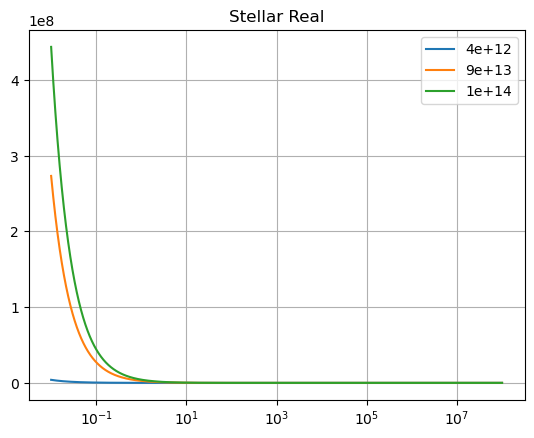

In [609]:
for mass, prof in zip(trial_M, trial_stel_real):
    plt.plot(trial_r, prof, label=f'{mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Stellar Real');

In [695]:
trial_stelProf.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.)
trial_stel_fourier = trial_stelProf.fourier(cosmo, trial_k, trial_M, 1)

[0.50052102 1.35862308 1.61082578]


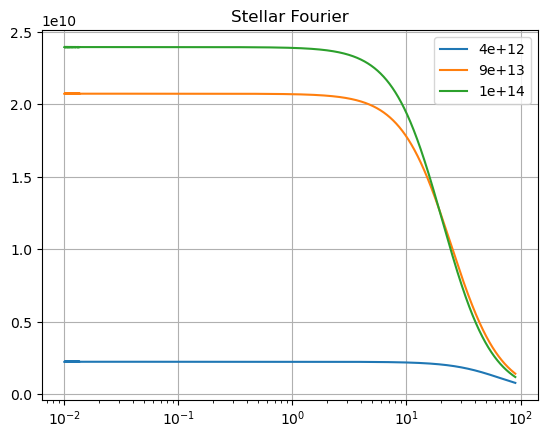

In [697]:
colours = ['tab:blue', 'orange', 'g']
for mass, prof, col in zip(trial_M, trial_stel_fourier, colours):
    plt.plot(trial_k, prof, label=f'{mass:.1g}')
   # plt.axhline(mass*trial_stelProf._f_stell(mass), color=col, linestyle='--');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Stellar Fourier');

In [615]:
trial_stelProf._f_stell(trial_M)

array([0.02288351, 0.01553537, 0.01293284])

## Gas

- The gas fraction in each halo approximately as:     
    - $f_g(m)=\frac{\Omega_b}{\Omega_m}\text{erf}\left[\frac{\log_{10}(m/m_{0g})}{\sigma_g}\right]$
    - for $m < m_{0g}$, we set $f_g\ = 0$

In [ ]:
def f_gas(m, ###
         m_0g= , sigma_g= 
         ):
    m_use = np.atleast_1d(m)
    f_array = np.zeros(np.shape(m_use))
    for i, mass in enumerate(m):
        if (mass < m_0g):
            f_array[i] = 0
        else:
            f_array[i] = (cosmo['Omega_b']/cosmo['Omega_m']) * erf(np.log10(mass/m_0g) / sigma_g)
    return f_array

In [128]:
### some values that will be put in init (of StellarProfile) as self.X
### using values in CCLX code for trial 0
m_0g = 5E12/cosmo['h']
sigma_g = 1.2

hmd_200m = ccl.halos.MassDef(200, 'matter')
#rho_avg_star = 7E8*cosmo['h']**2 # under rho_star in CCLX

# beta = 
# also want to have self.cosmo ?

- slightly different gas profile to Fedeli (2014) used in "Baryons_halo_model_power_spectrum" (CCLX):
    - $\rho_g(r)=\frac{\rho_{g,0}}{(1+u)^\beta(1+v^2)^{(7-\beta)/2}}$, with $u:=r/r_{co}$ and $v:=r/r_{ej}$.
- Fedeli 2014:
    - $\rho_g(r|m)=\frac{\rho_{c}}{(1+x^2)^{3\beta/2}}$, with $x:=r/r_{c}$
    - with the enforced relation of: $\frac{4}{3} \pi \rho_c r^3_c \left[ x_{\Delta}^3 ._2F_1 \left( \frac{3}{2}, \frac{3}{2}\beta, \frac{5}{2} ; -x^2_{\Delta} \right) \right] = m\ f_g(m)\ $
    - $x_{\Delta} = R_{\Delta}/r_c $
    - $._2F_1 \left( a, b, c; t \right) $ is the Gauss hypergeometric function $\to$ use scipy.special.hyp2f1(a, b, c, z, out=None)

In [672]:
class GasProfile(ccl.halos.profiles.profile_base.HaloProfile):
    """ Gas halo density profile. Fedeli (2014) arXiv:1401.2997
    """
    def __init__(self, mass_def):
        ### will put in other parameters here later
        super(GasProfile, self).__init__(mass_def=mass_def)

# want to have m_0g, sigma_g, & cosmo as self. in init
    def _f_gas(self, m):
        m_use = np.atleast_1d(m)
        f_array = np.zeros(np.shape(m_use))
        for i, mass in enumerate(m_use):
            if (mass < m_0g):
                f_array[i] = 0
            else:
                f_array[i] = (cosmo['Omega_b']/cosmo['Omega_m']) * erf(np.log10(mass/m_0g) / sigma_g)
        return f_array
    
    def _real(self, cosmo, r, M, scale_a=1, beta = 2/3, r_c = 1, xDel_ratio=1/0.05):
        """ X
        """
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # r_c = 
        r_vir = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a    # R_delta = the halo virial radius r_vir
        f_gas = self._f_gas(M_use)

        if xDel_ratio is None:
            x_delta = r_vir / r_c # use the inputted value of r_c
        else:
            # default: x_delta = 1/0.05 # in CCLX example, as paper have for their eg: r_c / r_Delta = 0.05
            x_delta = xDel_ratio  # reassign r_c in order to give the specific r_c/r_Del ratio desired 
            r_c = r_vir / x_delta

        rho_bracket = (x_delta**3) * hyp2f1(3/2, 3*beta/2, 5/2, -(x_delta**2))
        rho_c = 3 * M_use * f_gas / (4 * np.pi * (r_c**3) * rho_bracket)
        
        x = r_use[None, :] / r_c[:, None]
        prefix = rho_c * f_gas ## ASSUMING HERE that these are the prefix (relevant for [:, None] in next line)
        prof = prefix[:, None] / ((1 + x**2 )**(3 * beta / 2) )

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof


In [674]:
trial_gasProf = GasProfile(hmd_200m) # trying the mass_def CCLX used
trial_gas_real = trial_gasProf._real(cosmo, trial_r, trial_M)
trial_gas_real

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.03134591e+13, 2.03132607e+13, 2.03130621e+13, ...,
        9.58589308e-06, 9.58147959e-06, 9.57706813e-06],
       [2.46500662e+13, 2.46498938e+13, 2.46497213e+13, ...,
        1.62517118e-05, 1.62442293e-05, 1.62367502e-05]])

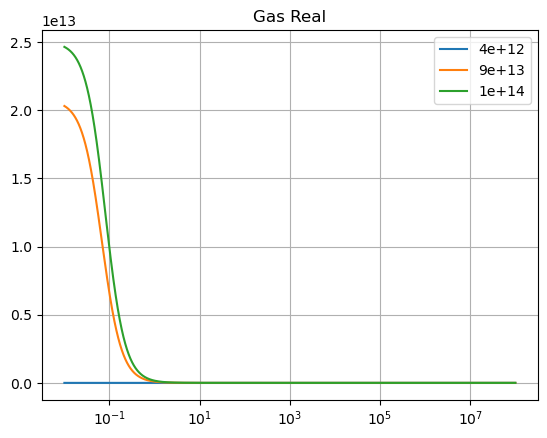

In [676]:
for mass, prof in zip(trial_M, trial_gas_real):
    plt.plot(trial_r, prof, label=f'{mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Gas Real');

In [621]:
trial_gasProf._f_gas(trial_M[0])

array([0.])

In [623]:
trial_gasProf.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.)
trial_gas_fourier = trial_gasProf.fourier(cosmo, trial_k, trial_M, 
                                          1)

In [625]:
trial_gasProf._f_gas(trial_M)
print(trial_M*trial_gasProf._f_gas(trial_M))
print(trial_gas_fourier)

[0.00000000e+00 1.13795073e+13 2.08283991e+13]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.88856144e+14 1.88822915e+14 1.88790655e+14 ... 5.78560671e+07
  5.78263454e+07 5.77966405e+07]
 [3.20142055e+14 3.20085720e+14 3.20031027e+14 ... 4.53259444e+07
  4.53072130e+07 4.52884941e+07]]


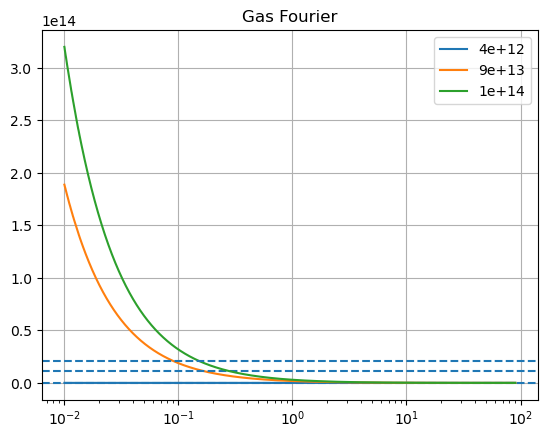

In [627]:
for mass, prof in zip(trial_M, trial_gas_fourier):
    plt.plot(trial_k, prof, label=f'{mass:.1g}');
    plt.axhline(mass*trial_gasProf._f_gas(mass), linestyle='--');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Gas Fourier');

In [629]:
trial_gasProf._f_gas(trial_M)

array([0.        , 0.13276092, 0.14579879])

In [631]:
for mass, prof in zip(trial_M, trial_gas_fourier):
    print(prof/trial_gasProf._f_gas(mass))

[nan nan nan ... nan nan nan]
[1.42252815e+15 1.42227786e+15 1.42203487e+15 ... 4.35791404e+08
 4.35567530e+08 4.35343782e+08]
[2.19577986e+15 2.19539347e+15 2.19501834e+15 ... 3.10880105e+08
 3.10751631e+08 3.10623242e+08]


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_4554/3308567100.py:2: RuntimeWarning: invalid value encountered in divide
  print(prof/trial_gasProf._f_gas(mass))


## Dark Matter

- Real density profile = NFW: $\rho_{DM}(x|m)\ = \frac{\rho_s}{x(1+x)^2} $
- where:
    - $x = r/r_s $
    - $\rho_s = $ the scale density of the profile
    - $r_s = $ the scale radius of the profile
- Also concentration $c \equiv R_{\Delta}/r_s$
- Constraint on scale density $\rho_s $ requires that the total DM mass w/in the structure matches the DM mass fraction
    - $\rho_s = f_{DM}\ \frac{\Delta}{3} \bar{\rho_m} \frac{c^3}{G(c)\ } $ , where $G(c)\ $ is the "usual NFW concentration function"

In [149]:
# The NFW profile to characterize the matter density around halos
help(trial_nfwProf._fourier)

Help on method _fourier_analytic in module pyccl.halos.profiles.nfw:

_fourier_analytic(cosmo, k, M, a) method of pyccl.halos.profiles.nfw.HaloProfileNFW instance



------------------------------------------------
Just go with NFW profile for the dark matter profile, so that:
- $\rho_{DM}(r|m)\ = \rho_{NFW}(r|m)\ * f_{DM}$
- Dark matter mass fraction: $f_{DM}(m, z)\ = 1 - \frac{ \Omega_{b,0} }{ \Omega_{m,0} } $

In [633]:
trial_nfw_real = trial_nfwProf._real(cosmo, trial_r, trial_M, 
                                     1)
trial_nfw_fourier = trial_nfwProf._fourier(cosmo, trial_k, trial_M, 
                                           1)

trial_nfw_real

array([[6.21968667e+15, 6.21778528e+15, 6.21588437e+15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53460065e+16, 1.53420944e+16, 1.53381832e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.75402850e+16, 1.75358926e+16, 1.75315011e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [635]:
f_dm = 1 - cosmo['Omega_b'] / cosmo['Omega_m']
f_dm

0.8333333333333333

In [637]:
trial_dm_real = f_dm * trial_nfw_real
trial_dm_fourier = f_dm * trial_nfw_fourier

trial_dm_real

array([[5.18307222e+15, 5.18148773e+15, 5.17990365e+15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.27883388e+16, 1.27850787e+16, 1.27818194e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.46169042e+16, 1.46132438e+16, 1.46095843e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

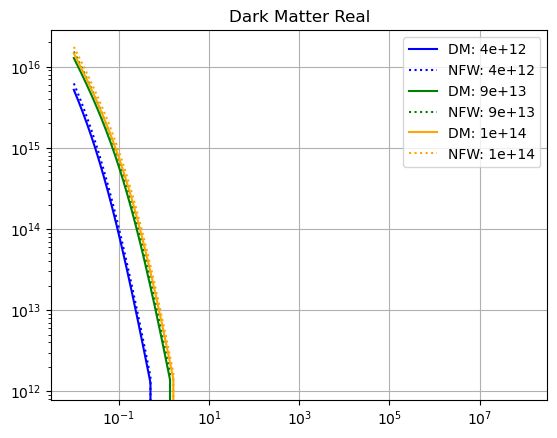

In [639]:
colours = ['b', 'g', 'orange']
for mass, prof, nfw, col in zip(trial_M, trial_dm_real, trial_nfw_real, colours):
    plt.plot(trial_r, prof, color=col, label=f'DM: {mass:.1g}');
    plt.plot(trial_r, nfw, ':', color=col, label=f'NFW: {mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title('Dark Matter Real');

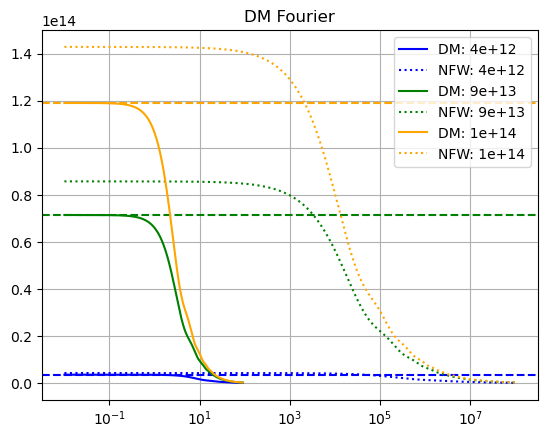

In [641]:
colours = ['b', 'g', 'orange']
for mass, prof, nfw, col in zip(trial_M, trial_dm_fourier, trial_nfw_fourier, colours):
    plt.plot(trial_k, prof, color=col, label=f'DM: {mass:.1g}');
    plt.axhline(mass*f_dm, color=col, linestyle='--');
    plt.plot(trial_r, nfw, ':', color=col, label=f'NFW: {mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('DM Fourier');

# Combine the profiles into 1 (sum)

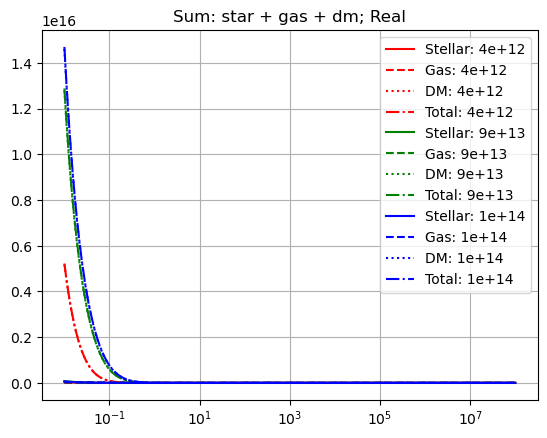

In [699]:
colours = ['r', 'g', 'b', 'k']
for mass, stel, gas, dm, col in zip(trial_M, trial_stel_real, trial_gas_real, trial_dm_real, colours):
    plt.plot(trial_r, stel, '-', color=col, label=f'Stellar: {mass:.1g}');
    plt.plot(trial_r, gas, '--', color=col, label=f'Gas: {mass:.1g}');
    plt.plot(trial_r, dm, ':', color=col, label=f'DM: {mass:.1g}');
    plt.plot(trial_r, dm+stel+gas, '-.', color=col, label=f'Total: {mass:.1g}');
    plt.legend(loc='best')
    plt.grid(True)
    plt.xscale('log')
    plt.title('Sum: star + gas + dm; Real');
   # plt.figure()

In [701]:
trial_sum_real = trial_stel_real + trial_gas_real + trial_dm_real
trial_sum_fourier = trial_stel_fourier + trial_gas_fourier + trial_dm_fourier

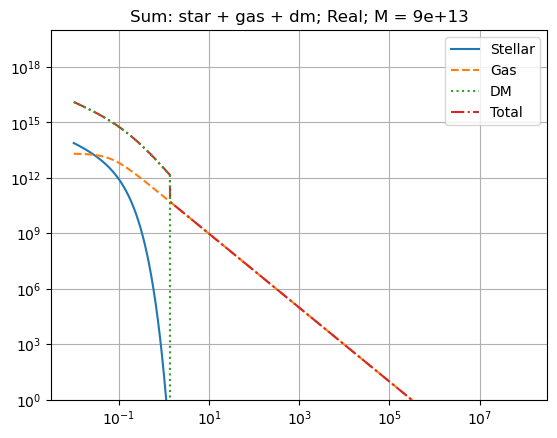

In [703]:
colours = ['r', 'g', 'b', 'k']
i = 1
plt.plot(trial_r, trial_stel_real[i], '-', label='Stellar');
plt.plot(trial_r, trial_gas_real[i], '--', label='Gas');
plt.plot(trial_r, trial_dm_real[i], ':', label='DM', zorder=5);
plt.plot(trial_r, trial_sum_real[i], '-.', label='Total');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1E0, 1E20)
plt.title(f'Sum: star + gas + dm; Real; M = {trial_M[i]:.1g}');

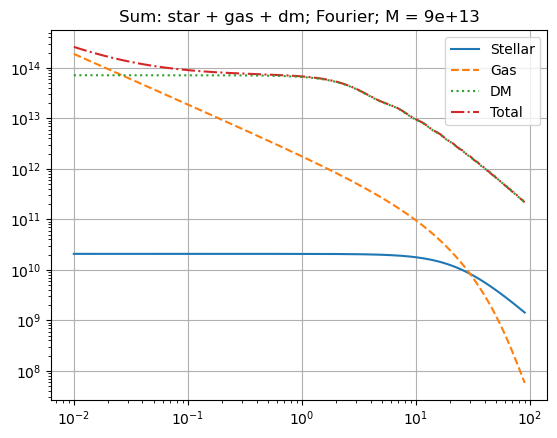

In [705]:
colours = ['r', 'g', 'b', 'k']
i = 1
plt.plot(trial_k, trial_stel_fourier[i], '-', label='Stellar');
plt.plot(trial_k, trial_gas_fourier[i], '--', label='Gas');
plt.plot(trial_k, trial_dm_fourier[i], ':', label='DM', zorder=5);
plt.plot(trial_k, trial_sum_fourier[i], '-.', label='Total');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title(f'Sum: star + gas + dm; Fourier; M = {trial_M[i]:.1g}');

In [394]:
trial_stel_fourier

array([[9.43340970e+08, 9.43278920e+08, 9.43216866e+08, ...,
        3.24179463e+01, 3.24120733e+01, 3.24062013e+01],
       [1.67257263e+10, 1.67255092e+10, 1.67252921e+10, ...,
        2.90020851e+03, 2.89968079e+03, 2.89915317e+03],
       [2.06887255e+10, 2.06885304e+10, 2.06883354e+10, ...,
        4.93814438e+03, 4.93724566e+03, 4.93634710e+03]])

In [396]:
trial_dm_fourier

array([[2.49999800e+12, 2.49999800e+12, 2.49999800e+12, ...,
        8.49282482e+10, 8.49177576e+10, 8.49072608e+10],
       [4.99996849e+13, 4.99996848e+13, 4.99996847e+13, ...,
        1.99237357e+11, 1.99227192e+11, 1.99216986e+11],
       [8.33325866e+13, 8.33325865e+13, 8.33325863e+13, ...,
        2.27852478e+11, 2.27815867e+11, 2.27778838e+11]])

# Compare with BCM

In [399]:
import BCMprofiles_hopefulFinal as BCMprofiles
BCMprofiles.__all__

('Initialiser',
 'StellarProfile',
 'EjectedGasProfile',
 'BoundGasProfile',
 'CDMProfile',
 'BCMProfile')

In [413]:
cdm_profile.mass_def

MassDef(Delta=200, rho_type=critical)

In [425]:
trial_gamma = 1.1 
# using as the mass_def here
cdm_profile = BCMprofiles.CDMProfile(cosmo, hmd_200m, cM, trial_gamma)
stel_profile = BCMprofiles.StellarProfile(cosmo, hmd_200m, cM, trial_gamma)
ej_profile = BCMprofiles.EjectedGasProfile(cosmo, hmd_200m, cM, trial_gamma)
bd_profile = BCMprofiles.BoundGasProfile(cosmo, hmd_200m, cM, trial_gamma)
bcm_profile = BCMprofiles.BCMProfile(cosmo, hmd_200m, cM, trial_gamma)

In [427]:
cdm_real = cdm_profile._real(cosmo, trial_r, trial_M)
stel_real = stel_profile._real(cosmo, trial_r, trial_M)
ej_real = ej_profile._real(cosmo, trial_r, trial_M)
bd_real = bd_profile._real(cosmo, trial_r, trial_M)
bcm_real = bcm_profile._real(cosmo, trial_r, trial_M)

In [429]:
cdm_fourier = cdm_profile._fourier(trial_k, trial_M)
stel_fourier = stel_profile._fourier(trial_k, trial_M)
ej_fourier = ej_profile._fourier(trial_k, trial_M)
bd_fourier = bd_profile._fourier(trial_k, trial_M)
bcm_fourier = bcm_profile._fourier(trial_k, trial_M)

Qany = 1.56% through
Qany = 3.12% through
Qany = 4.69% through
Qany = 6.25% through
Qany = 7.81% through
Qany = 9.38% through
Qany = 10.9% through
Qany = 12.5% through
Qany = 14.1% through
Qany = 15.6% through
Qany = 17.2% through
Qany = 18.8% through
Qany = 20.3% through
Qany = 21.9% through
Qany = 23.4% through
Qany = 25% through
Qany = 26.6% through
Qany = 28.1% through
Qany = 29.7% through
Qany = 31.2% through
Qany = 32.8% through
Qany = 34.4% through
Qany = 35.9% through
Qany = 37.5% through
Qany = 39.1% through
Qany = 40.6% through
Qany = 42.2% through
Qany = 43.8% through
Qany = 45.3% through
Qany = 46.9% through
Qany = 48.4% through
Qany = 50% through
Qany = 51.6% through
Qany = 53.1% through
Qany = 54.7% through
Qany = 56.2% through
Qany = 57.8% through
Qany = 59.4% through
Qany = 60.9% through
Qany = 62.5% through
Qany = 64.1% through
Qany = 65.6% through
Qany = 67.2% through
Qany = 68.8% through
Qany = 70.3% through
Qany = 71.9% through
Qany = 73.4% through
Qany = 75% throug

In [707]:
print(f'For BCM\nf_cdm = {bcm_profile.f_c}')
print(f'f_* = {bcm_profile._f_bd(trial_M)[1]}') 
print(f'f_bd = {bcm_profile._f_bd(trial_M)[0]}') # f_bd, then f_stell
print(f'f_ej = {bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1] - bcm_profile._f_bd(trial_M)[0]}') 
print(f'f_gas = {bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1]}')

trial_stelProf
print(f'\nFor SAM (Fedeli 2014)\nf_cdm = {f_dm}')
print(f'f_* = {trial_stelProf._f_stell(trial_M)}')  
print(f'f_gas = {trial_gasProf._f_gas(trial_M)}')

For BCM
f_cdm = 0.8333333333333333
f_* = [0.02981898 0.01470412 0.01159136]
f_bd = [0.03169744 0.09805594 0.11040291]
f_ej = [0.10515024 0.05390661 0.0446724 ]
f_gas = [0.13684768 0.15196255 0.15507531]

For SAM (Fedeli 2014)
f_cdm = 0.8333333333333333
f_* = [0.02288351 0.01553537 0.01293284]
f_gas = [0.         0.13276092 0.14579879]


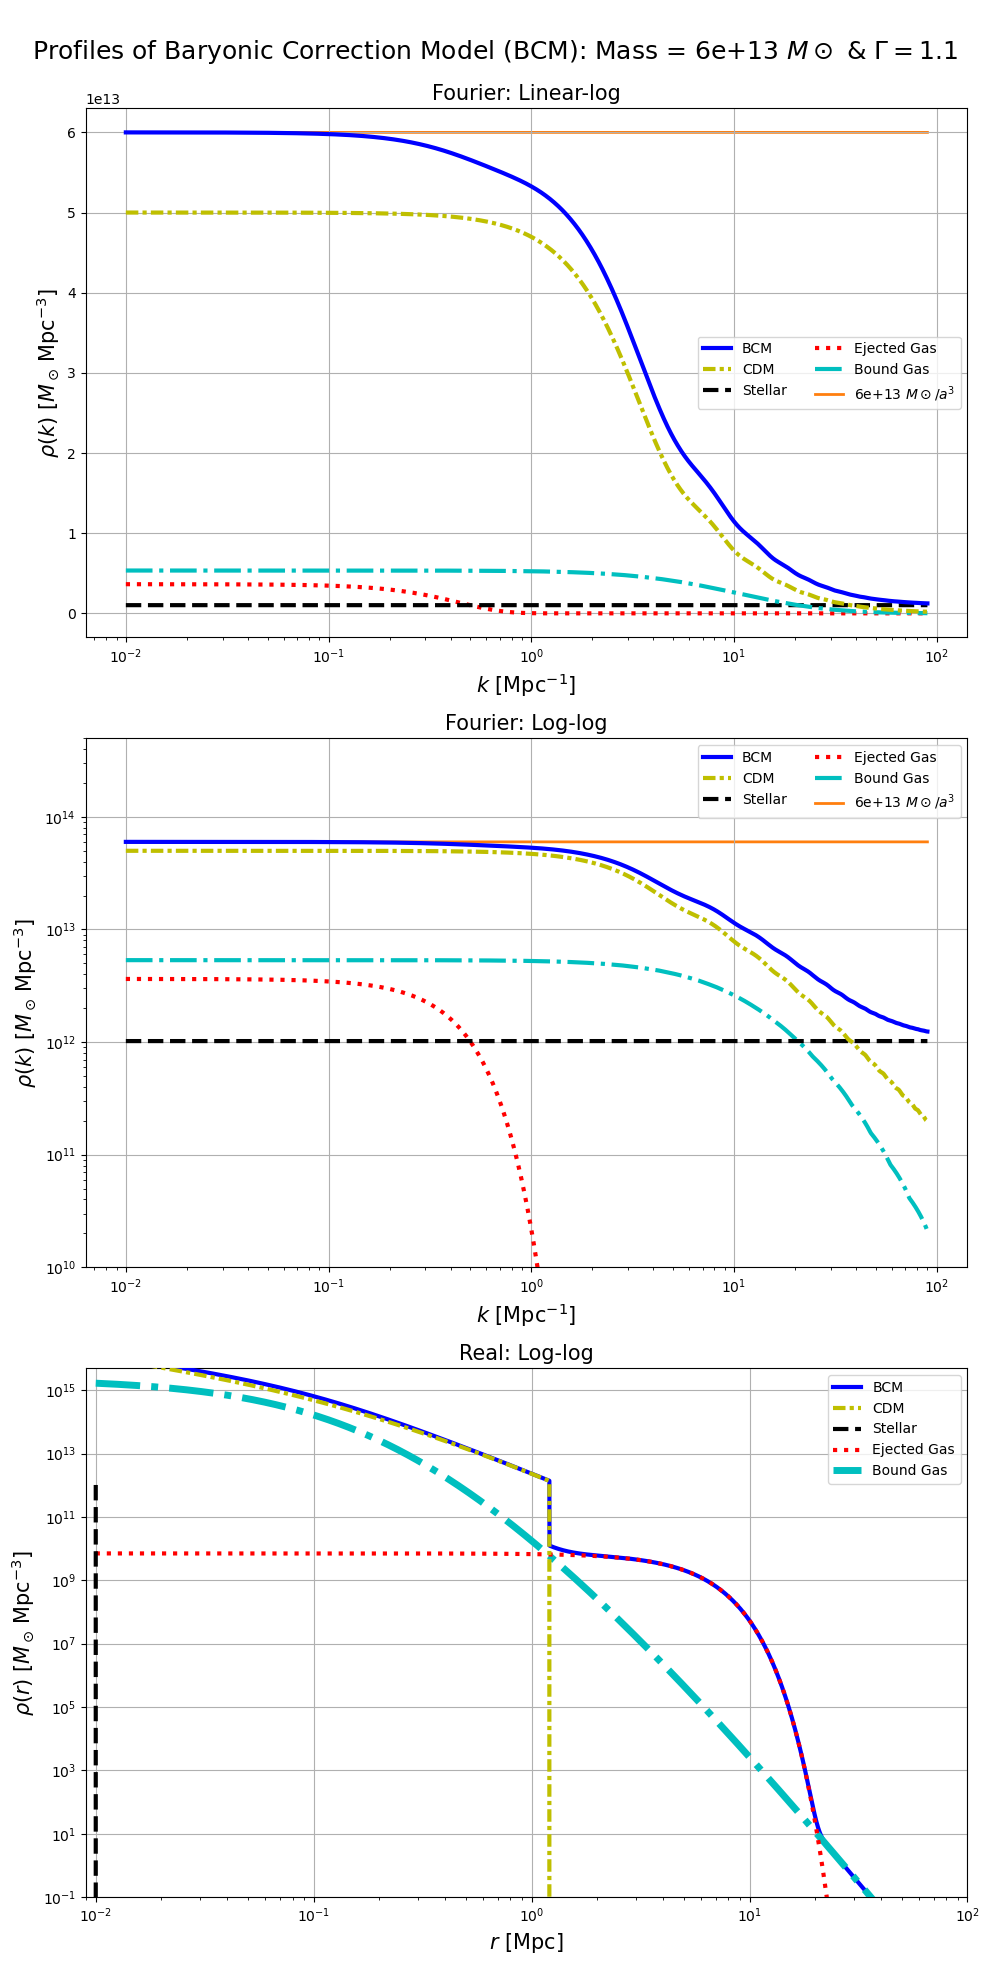

In [431]:
i = 1
title_combined = f'\nProfiles of Baryonic Correction Model (BCM): Mass = {trial_M[i]:.1g} $M \\odot$ & $\\Gamma = ${trial_gamma}\n' 
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,20))
fig.suptitle(title_combined, fontsize=18)

ax1.plot(trial_k, bcm_fourier[i], 'b-', 
         lw=3, zorder = 5, label='BCM')
ax1.plot(trial_k, cdm_fourier[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=6, label='CDM')
ax1.plot(trial_k, stel_fourier[i], 'k--', lw=3, zorder = 3, label='Stellar')
ax1.plot(trial_k, ej_fourier[i], 'r:', 
         lw=3, zorder = 2, label='Ejected Gas')
ax1.plot(trial_k, bd_fourier[0,i], 'c-.', 
         lw=3, zorder = 4, label='Bound Gas')
ax1.plot(trial_k, 1*trial_k + trial_M[i], 'tab:orange', zorder=1, lw=2, label=f'{trial_M[i]:.1g} $M \\odot /a^3$')
    
ax1.set_ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax1.set_xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
ax1.set_title('Fourier: Linear-log', fontsize=15)
ax1.grid(True)
ax1.legend(loc='best', ncol=2)
ax1.set_xscale('log'); 
##########################
ax2.plot(trial_k, bcm_fourier[i], 'b-', lw=3, zorder = 5, label='BCM')
ax2.plot(trial_k, cdm_fourier[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=6, label='CDM')
ax2.plot(trial_k, stel_fourier[i], 'k--', lw=3, zorder = 5, label='Stellar')
ax2.plot(trial_k, ej_fourier[i], 'r:', lw=3, zorder = 4, label='Ejected Gas')
ax2.plot(trial_k, bd_fourier[0,i], 'c-.', lw=3, zorder = 3, label='Bound Gas')
ax2.plot(trial_k, 1*trial_k + trial_M[i], 'tab:orange', zorder=1, lw=2, label=f'{trial_M[i]:.1g} $M \\odot /a^3$')
    
ax2.set_ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax2.set_xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
ax2.set_title('Fourier: Log-log', fontsize=15)
ax2.grid(True)
ax2.legend(loc='best', ncol=2)
ax2.set_xscale('log'); 
ax2.set_ylim(1E10, 5E14)
#ax2.set_ylim(5E10)
ax2.set_yscale('log');
#########################
ax3.plot(trial_r, bcm_real[i], 'b-', lw=3, zorder = 3, label='BCM')
ax3.plot(trial_r, cdm_real[i], linestyle=(0, (3,1,1,1)), color='y', lw=3, 
         zorder=7, label='CDM')
ax3.plot(trial_r, stel_real[i], 'k--', lw=3, zorder = 5, label='Stellar')
ax3.plot(trial_r, ej_real[i], 'r:', lw=3, zorder = 4, label='Ejected Gas')
ax3.plot(trial_r, bd_real[i], 'c-.', lw=5, zorder = 3, label='Bound Gas')
    
ax3.set_ylabel(r'$\rho(r)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
ax3.set_xlabel(r'$r\, \,[{\rm Mpc}]$', fontsize=15);
ax3.set_title('Real: Log-log', fontsize=15)
ax3.grid(True)
ax3.legend(loc='best')
ax3.set_xscale('log'); 
ax3.set_ylim(1E-1, 5E15)
ax3.set_xlim(9E-3, 1E2)
ax3.set_yscale('log');

fig.tight_layout();

In [432]:
bd_fourier

array([[[8.02550495e+10, 8.02550495e+10, 8.02550495e+10, ...,
         1.00260691e+10, 1.00243691e+10, 1.00226690e+10],
        [5.34178976e+12, 5.34178976e+12, 5.34178976e+12, ...,
         2.10665161e+10, 2.10576014e+10, 2.10486867e+10],
        [1.01873531e+13, 1.01873531e+13, 1.01873531e+13, ...,
         1.93018199e+10, 1.92934168e+10, 1.92850137e+10]]])

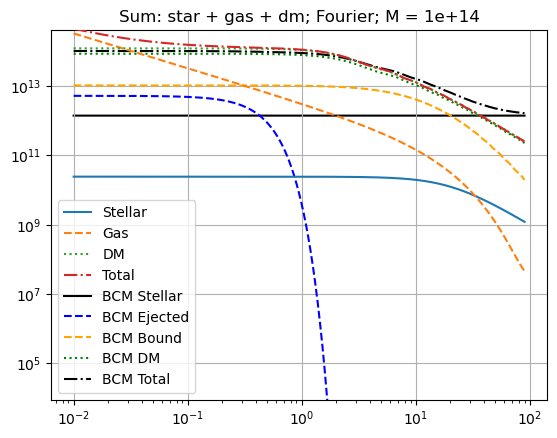

In [709]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate
plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[1], zorder=7, label='Gas');
plt.plot(trial_k, trial_dm_fourier[i], ':', color=colours[2], label='DM', zorder=8);
plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[3], zorder=9, label='Total');

plt.plot(trial_k, stel_fourier[i], 'k-', zorder=1, label='BCM Stellar');
plt.plot(trial_k, ej_fourier[i], 'b--', zorder=2, label='BCM Ejected');
plt.plot(trial_k, bd_fourier[0,i], '--', color='orange', zorder=3, label='BCM Bound');
plt.plot(trial_k, cdm_fourier[i], 'g:', zorder=4, label='BCM DM');
plt.plot(trial_k, bcm_fourier[i], 'k-.', zorder=5, label='BCM Total');
plt.legend(loc='best')
plt.grid(True)
#plt.ylim(9E3, 4E14)
plt.xscale('log')
plt.yscale('log')
plt.title(f'Sum: star + gas + dm; Fourier; M = {trial_M[i]:.1g}');

In [555]:
trial_gas_fourier

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.22995874e+14, 1.22974235e+14, 1.22953227e+14, ...,
        6.71382425e+07, 6.71034773e+07, 6.70687298e+07],
       [2.23527906e+14, 2.23488576e+14, 2.23450392e+14, ...,
        5.35100094e+07, 5.34833894e+07, 5.34567853e+07]])

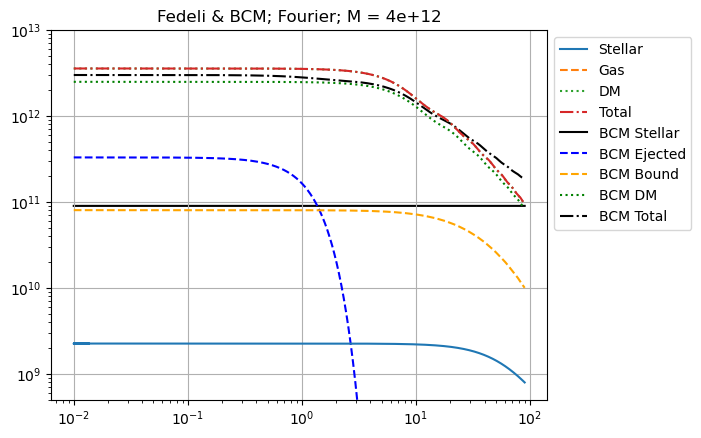

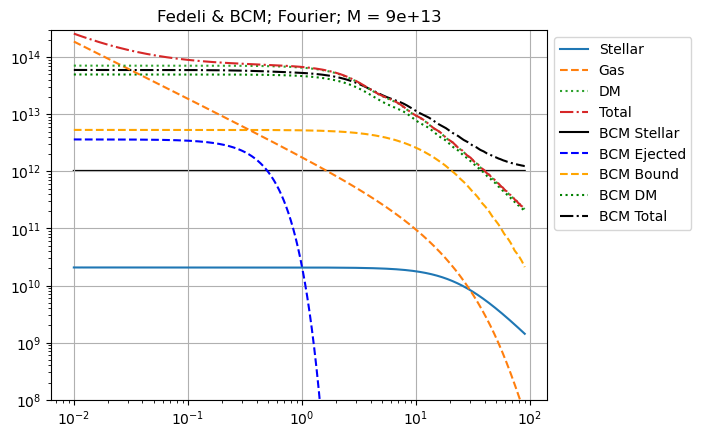

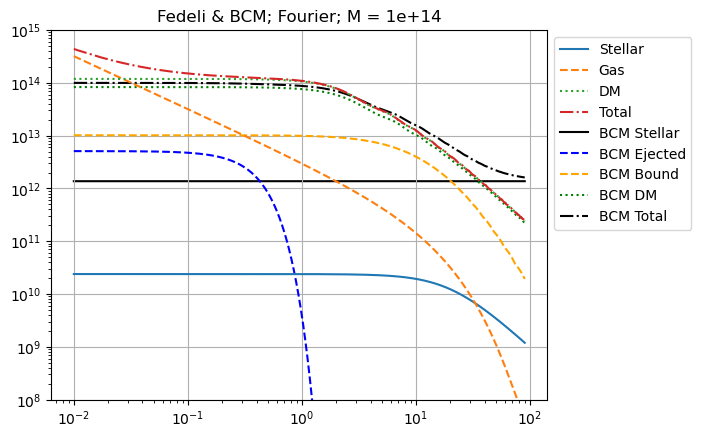

<Figure size 640x480 with 0 Axes>

In [717]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_k, trial_dm_fourier[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_k, stel_fourier[i], 'k-', zorder=1, label='BCM Stellar');
    plt.plot(trial_k, ej_fourier[i], 'b--', zorder=2, label='BCM Ejected');
    plt.plot(trial_k, bd_fourier[0,i], '--', color='orange', zorder=3, label='BCM Bound');
    plt.plot(trial_k, cdm_fourier[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    ylim_upper, ylim_lower = [1E13, 3E14, 1E15], [5E8, 1E8, 1E8]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

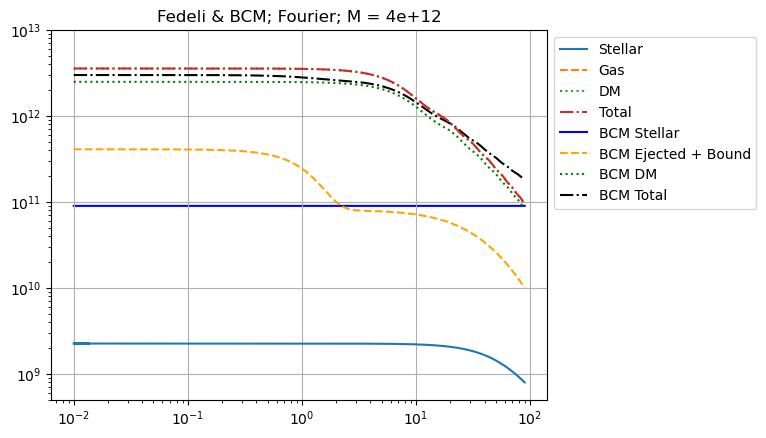

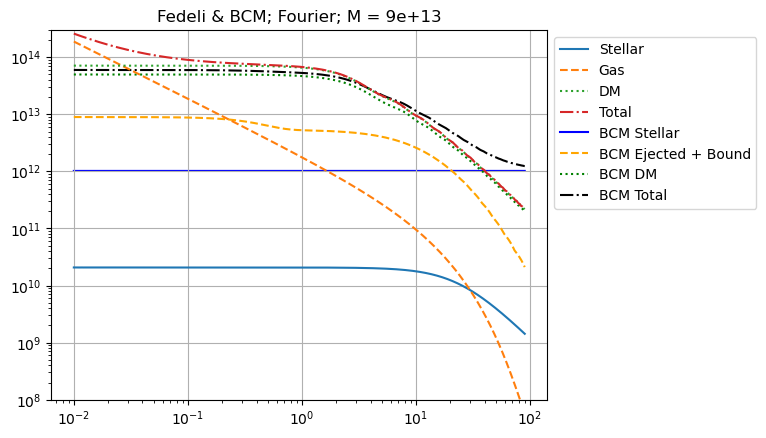

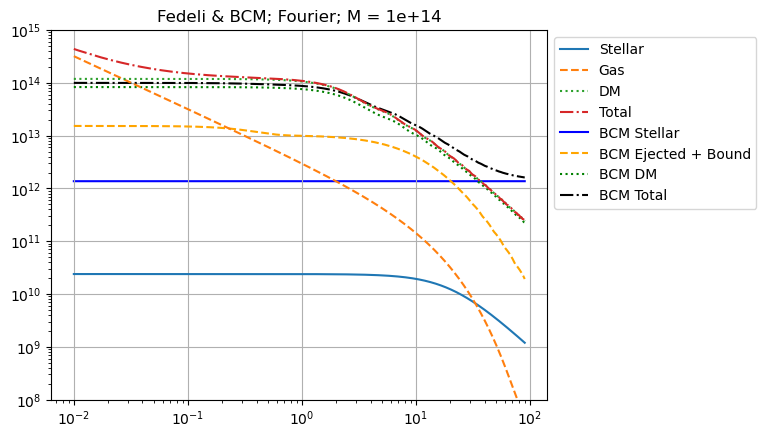

<Figure size 640x480 with 0 Axes>

In [719]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
ylim_plot = []
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_k, trial_dm_fourier[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_k, stel_fourier[i], 'b-', zorder=1, label='BCM Stellar');
    plt.plot(trial_k, ej_fourier[i]+bd_fourier[0,i], '--', color='orange', zorder=2, label='BCM Ejected + Bound');
    plt.plot(trial_k, cdm_fourier[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    ylim_upper, ylim_lower = [1E13, 3E14, 1E15], [5E8, 1E8, 1E8]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

## Components

In [438]:
trial_gas_fourier

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.79151137e+11, 3.79072917e+11, 3.78996992e+11, ...,
        2.85407981e+04, 2.85407984e+04, 2.85407988e+04],
       [9.94277570e+11, 9.94077363e+11, 9.93883020e+11, ...,
        7.29247422e+04, 7.29247431e+04, 7.29247440e+04]])

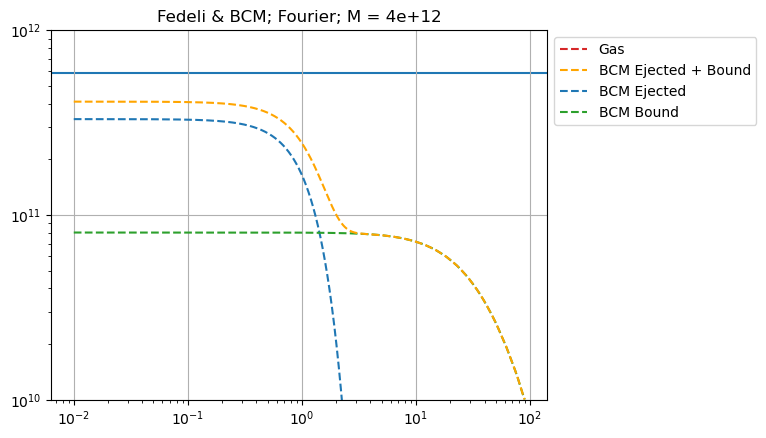

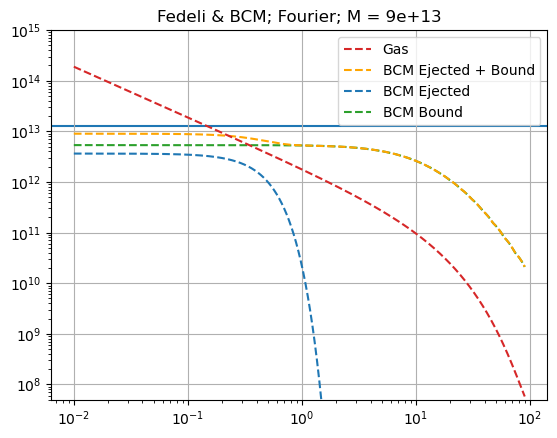

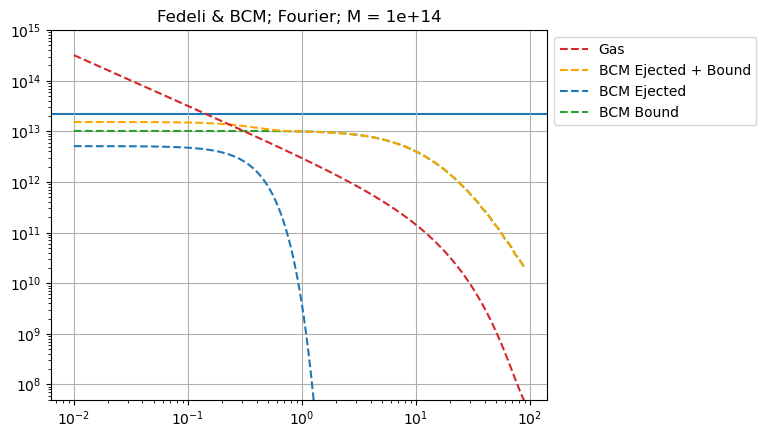

<Figure size 640x480 with 0 Axes>

In [721]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
ylim_plot = []
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[3], zorder=7, label='Gas');
    
    plt.plot(trial_k, ej_fourier[i]+bd_fourier[0,i], '--', color='orange', zorder=4, label='BCM Ejected + Bound');
    plt.plot(trial_k, ej_fourier[i], '--', color='tab:blue', zorder=2, label='BCM Ejected');
    plt.plot(trial_k, bd_fourier[0,i], '--', color='tab:green', zorder=3, label='BCM Bound');
    plt.axhline(mass*(bcm_profile.f_bar_b - bcm_profile._f_bd(trial_M)[1][i]), zorder=1)
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    ylim_upper, ylim_lower = [1E12, 1E15, 1E15], [1E10, 5E7, 5E7]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

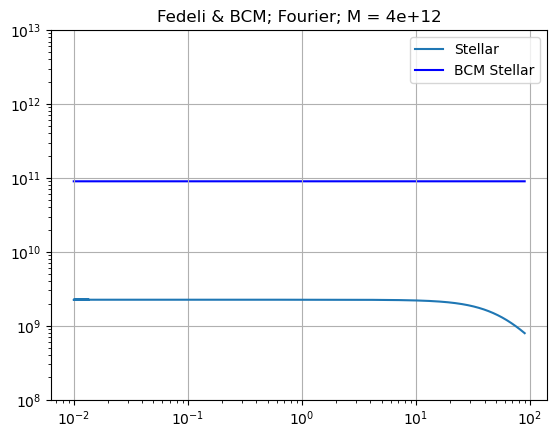

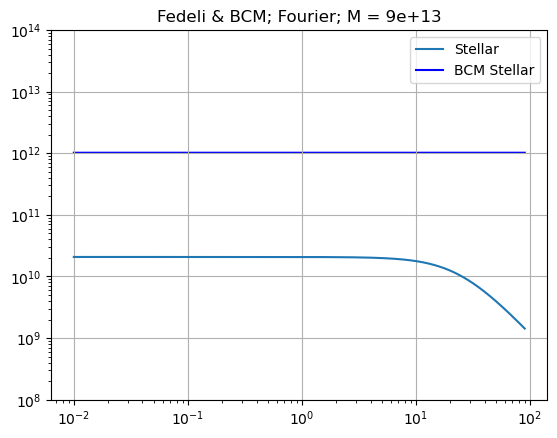

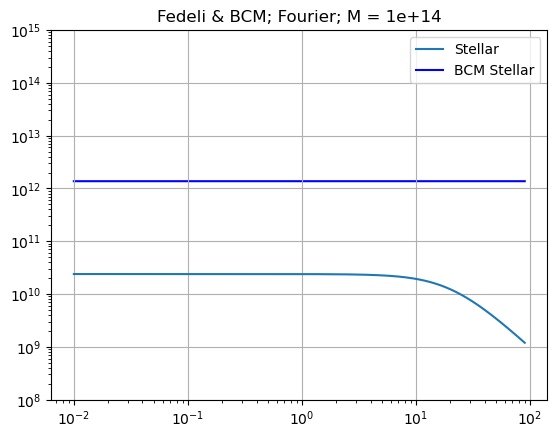

<Figure size 640x480 with 0 Axes>

In [727]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    
    plt.plot(trial_k, stel_fourier[i], 'b-', zorder=1, label='BCM Stellar');
    plt.legend(loc='best')
    plt.grid(True)
    ylim_upper, ylim_lower = 1*10**(13+i), 1E8 #[1E4, 1E3, 1E3]
    plt.ylim(ylim_lower, ylim_upper)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

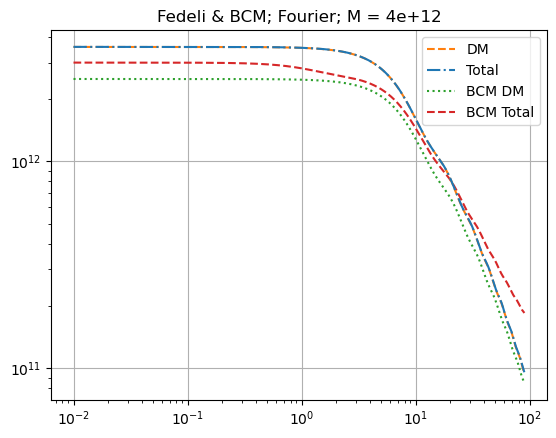

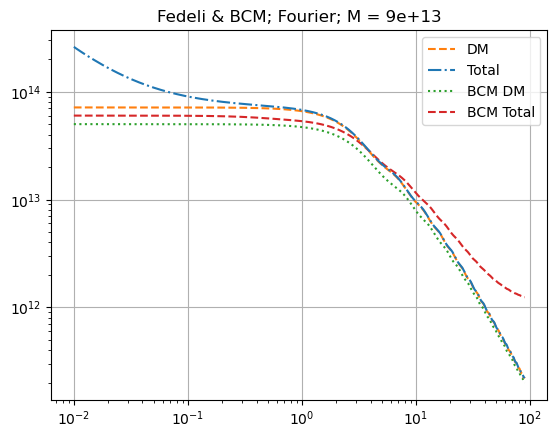

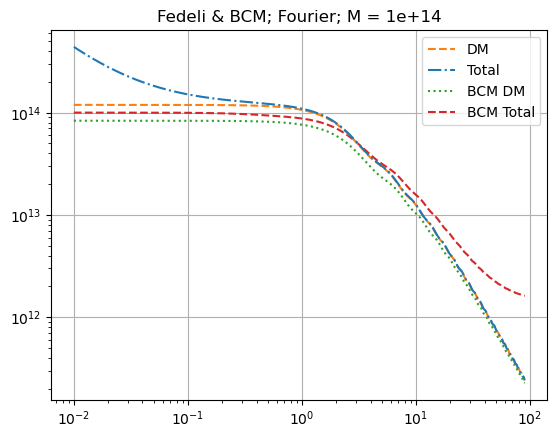

<Figure size 640x480 with 0 Axes>

In [729]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_dm_fourier[i], '--', color=colours[1], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[0], zorder=9, label='Total');
    
    plt.plot(trial_k, cdm_fourier[i], ':', color=colours[2], zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], '--', color=colours[3], zorder=5, label='BCM Total');
    plt.legend(loc='best')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

In [443]:
stel_fourier

array([[8.99836441e+10, 8.99836441e+10, 8.99836441e+10, ...,
        8.99836441e+10, 8.99836441e+10, 8.99836441e+10],
       [1.02075232e+12, 1.02075232e+12, 1.02075232e+12, ...,
        1.02075232e+12, 1.02075232e+12, 1.02075232e+12],
       [1.37350009e+12, 1.37350009e+12, 1.37350009e+12, ...,
        1.37350009e+12, 1.37350009e+12, 1.37350009e+12]])

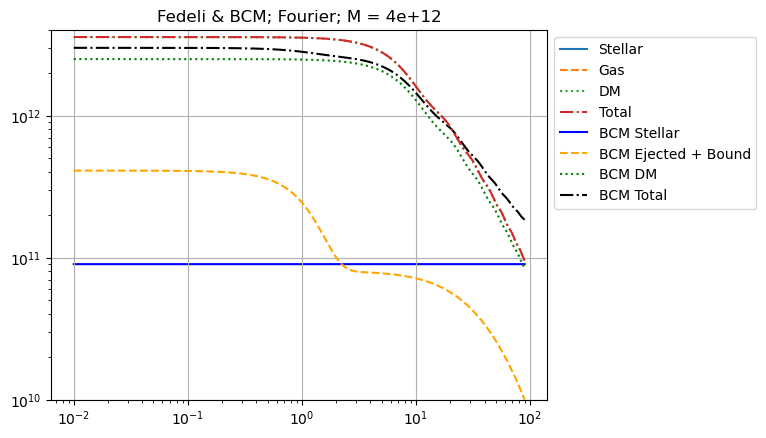

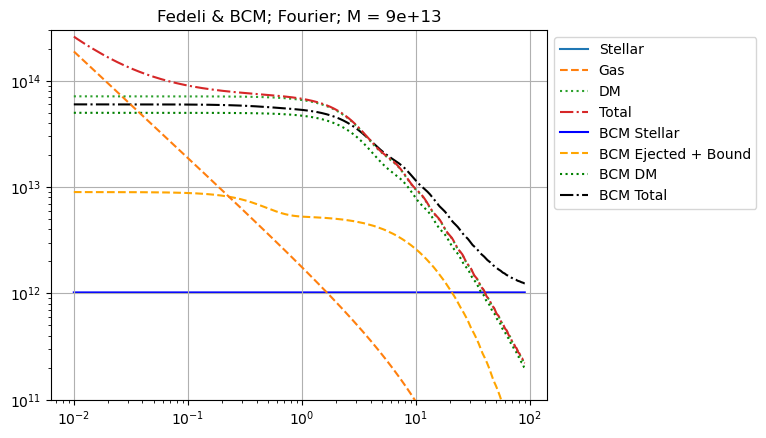

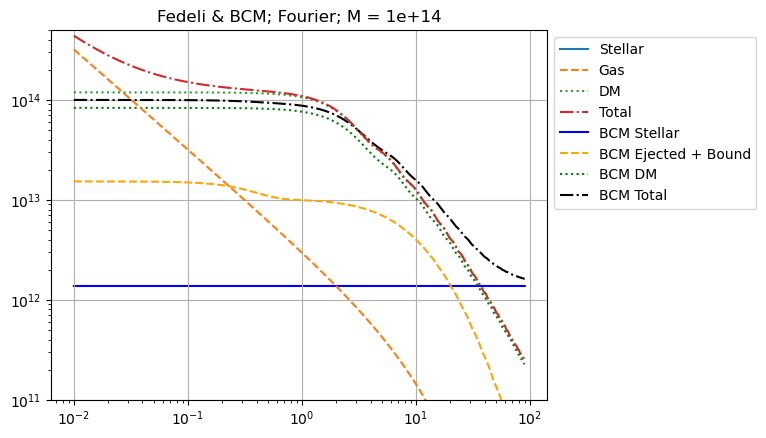

<Figure size 640x480 with 0 Axes>

In [733]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']

for i, mass in enumerate(trial_M):
    plt.plot(trial_k, trial_stel_fourier[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_k, trial_gas_fourier[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_k, trial_dm_fourier[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_k, trial_sum_fourier[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_k, stel_fourier[i], 'b-', zorder=1, label='BCM Stellar');
    plt.plot(trial_k, ej_fourier[i]+bd_fourier[0,i], '--', color='orange', zorder=2, label='BCM Ejected + Bound');
    plt.plot(trial_k, cdm_fourier[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_k, bcm_fourier[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.grid(True)
    ylim_lower, ylim_upper = [1E10, 1E11, 1E11], [4E12, 3E14, 5E14]
    plt.ylim(ylim_lower[i], ylim_upper[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Fourier; M = {mass:.1g}');
    plt.figure();

### Comparing the real profiles

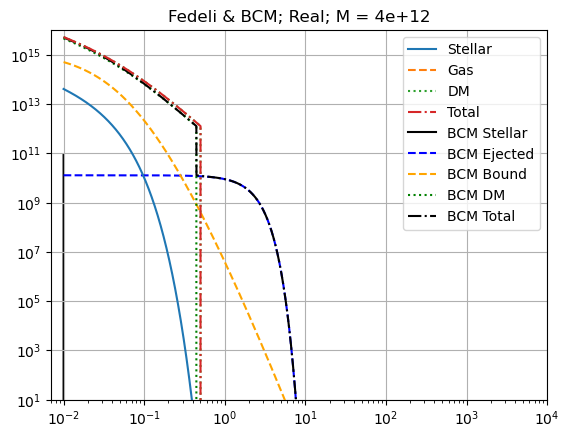

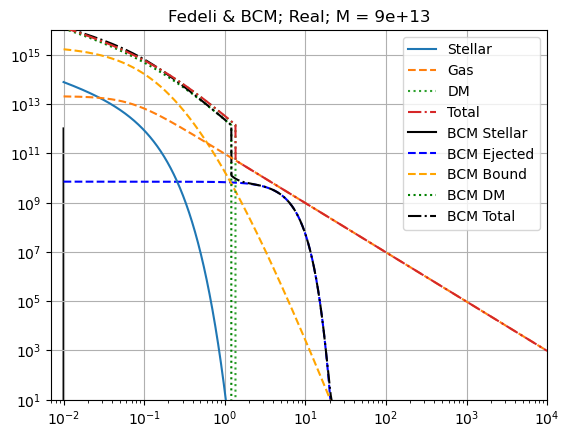

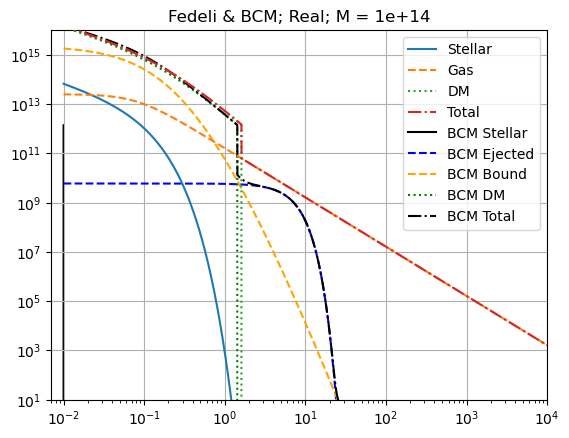

<Figure size 640x480 with 0 Axes>

In [735]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] #['r', 'g', 'b', 'k']
for i, mass in enumerate(trial_M):
    plt.plot(trial_r, trial_stel_real[i], '-', color=colours[0], zorder=6, label='Stellar');
    plt.plot(trial_r, trial_gas_real[i], '--', color=colours[1], zorder=7, label='Gas');
    plt.plot(trial_r, trial_dm_real[i], ':', color=colours[2], label='DM', zorder=8);
    plt.plot(trial_r, trial_sum_real[i], '-.', color=colours[3], zorder=9, label='Total');
    
    plt.plot(trial_r, stel_real[i], 'k-', zorder=1, label='BCM Stellar');
    plt.plot(trial_r, ej_real[i], 'b--', zorder=2, label='BCM Ejected');
    plt.plot(trial_r, bd_real[i], '--', color='orange', zorder=3, label='BCM Bound');
    plt.plot(trial_r, cdm_real[i], 'g:', zorder=4, label='BCM DM');
    plt.plot(trial_r, bcm_real[i], 'k-.', zorder=5, label='BCM Total');
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.grid(True)
    plt.ylim(1E1, 1E16)
    plt.xlim(7E-3, 1E4)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fedeli & BCM; Real; M = {mass:.1g}');
    plt.figure();